請你幫我製作玉米期貨的PnL (profit and loss) curve，為了幫助理解這個問題，可以依據以下的步驟進行。

1. 在每個交易日，皆存在著不同到期日的合約。在你分析的商品中，哪些到期月份的合約的交易量是最大的？

2. 市場慣性交易熱門月的合約，在每個交易日，請以最接近到期的熱門月合約做為持倉依據。

3. 請製作出一個函數，能給定在到期日前N日進行轉倉(rolling)，以收盤價計算出每日損益 (daily return)。

4. 請注意，在轉倉日時，會有相對應的轉倉成本，請思考該如何正確地估計它，可能為正或負，請將它計入每日損益。

5. 最後，請將每日損益進行累積和(cumulative sum)，並將圖畫出來，並將其與單純價格的pnl比較：請問你處理的商品的轉倉成本是偏正還是偏負？是什麼原因影響了轉倉成本？請將你做的曲線以及發現記錄下來。

### 2023/8/18:
    * 加入每個時期手上擁有的期貨合約Id為一條column
    * cumsum起來作圖
    * 更新第一二題
    
    

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas.tseries.offsets import BDay  # not include national holidays, etc
from dateutil.relativedelta import relativedelta

In [46]:
corn_data = pd.read_csv('contracts_c_corn.csv')
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN


In [47]:
dt_list = []
exp_dt_list = []

for i in range(len(corn_data)):
    try:
        dt_list.append(datetime.strptime(corn_data['Date'][i], '%d/%m/%Y'))
    except:
        dt_list.append(0)
    try:
        exp_dt_list.append(datetime.strptime(corn_data['exp_date'][i], '%d/%m/%Y'))
    except:
        exp_dt_list.append(0)
    
corn_data['dt'] = dt_list
corn_data['exp_dt'] = exp_dt_list
corn_data.tail()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,2021-09-03,2023-09-14 00:00:00
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,2021-09-03,2021-12-14 00:00:00
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,2021-09-03,2022-12-14 00:00:00
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,2021-09-03,2023-12-14 00:00:00
75301,CZ24,3/9/2021,4.3550,4.3500,4.3600,4.3500,1141,13,13/12/2024,29/11/2024,2021-09-03,2024-12-13 00:00:00


In [48]:
exp_month_list = []
for date in corn_data['exp_dt']:
    try:
        exp_month_list.append(date.month)
    except:
        exp_month_list.append(0)
month_list = []
for date in corn_data['dt']:
    try:
        month_list.append(date.month)
    except:
        month_list.append(0)

corn_data['month'] = month_list  
corn_data['exp_month'] = exp_month_list
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,2000-01-03,2001-01-12 00:00:00,1,1
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,2000-01-03,2000-03-14 00:00:00,1,3
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,2000-01-03,2001-03-14 00:00:00,1,3
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,2000-01-03,2000-05-12 00:00:00,1,5
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,2000-01-03,2000-07-14 00:00:00,1,7


In [55]:
per = corn_data.dt.dt.to_period("M")
corn_data['max_vol'] = corn_data.groupby(per)['volume'].transform('max')
corn_data

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,2000-01-03,2001-01-12 00:00:00,1,1,121537
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,2000-01-03,2000-03-14 00:00:00,1,3,121537
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,2000-01-03,2001-03-14 00:00:00,1,3,121537
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,2000-01-03,2000-05-12 00:00:00,1,5,121537
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,2000-01-03,2000-07-14 00:00:00,1,7,121537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,2021-09-03,2023-09-14 00:00:00,9,9,190162
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,2021-09-03,2021-12-14 00:00:00,9,12,190162
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,2021-09-03,2022-12-14 00:00:00,9,12,190162
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,2021-09-03,2023-12-14 00:00:00,9,12,190162


In [76]:
corn_data['month'] = per
corn_data

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,2000-01-03,2001-01-12 00:00:00,2000-01,1,121537
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,2000-01-03,2000-03-14 00:00:00,2000-01,3,121537
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,2000-01-03,2001-03-14 00:00:00,2000-01,3,121537
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,2000-01-03,2000-05-12 00:00:00,2000-01,5,121537
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,2000-01-03,2000-07-14 00:00:00,2000-01,7,121537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,2021-09-03,2023-09-14 00:00:00,2021-09,9,190162
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,2021-09-03,2021-12-14 00:00:00,2021-09,12,190162
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,2021-09-03,2022-12-14 00:00:00,2021-09,12,190162
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,2021-09-03,2023-12-14 00:00:00,2021-09,12,190162


In [79]:
def get_highest_vol(x):
    df = x.sort_values(by='volume', ascending=True)
    return df.iloc[-1,:]
highest_vol = corn_data.groupby(per).apply(get_highest_vol)
highest_vol = highest_vol.reset_index(drop = True)
highest_vol

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol
0,CH00,12/1/2000,2.1550,2.0700,2.1675,2.0675,0,121537,14/3/2000,NaN,2000-01-12,2000-03-14,2000-01,3,121537
1,CH00,28/2/2000,2.1200,2.1300,2.1400,2.1175,0,63529,14/3/2000,NaN,2000-02-28,2000-03-14,2000-02,3,63529
2,CK00,14/3/2000,2.3800,2.3075,2.3825,2.3075,0,83876,12/5/2000,NaN,2000-03-14,2000-05-12,2000-03,5,83876
3,CK00,27/4/2000,2.2525,2.2750,2.2775,2.2500,0,53134,12/5/2000,NaN,2000-04-27,2000-05-12,2000-04,5,53134
4,CN00,3/5/2000,2.5075,2.4600,2.5825,2.4425,0,104819,14/7/2000,NaN,2000-05-03,2000-07-14,2000-05,7,104819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,CN21,14/5/2021,6.4375,6.7000,6.8700,6.4175,683888,279993,14/7/2021,30/6/2021,2021-05-14,2021-07-14,2021-05,7,279993
257,CZ21,30/6/2021,5.8850,5.4650,5.8850,5.2825,592282,272458,14/12/2021,30/11/2021,2021-06-30,2021-12-14,2021-06,12,272458
258,CZ21,1/7/2021,5.8900,5.9475,6.1125,5.8400,603847,206187,14/12/2021,30/11/2021,2021-07-01,2021-12-14,2021-07,12,206187
259,CZ21,12/8/2021,5.7325,5.5750,5.9425,5.5150,723846,414290,14/12/2021,30/11/2021,2021-08-12,2021-12-14,2021-08,12,414290


In [82]:
freq = highest_vol["exp_month"].value_counts()
print(freq)

12    120
3      62
7      43
5      36
Name: exp_month, dtype: int64


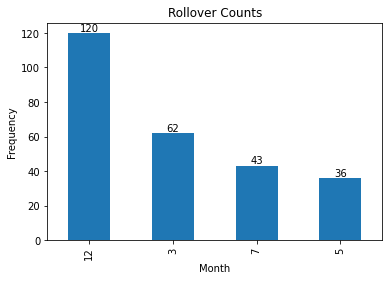

In [83]:
fig = freq.plot(kind = 'bar')
fig.bar_label(fig.containers[0])
plt.title('Rollover Counts')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

將合約依照月份分群，計算市場上平均交易量最高的合約，得到玉米期貨在3、5、7、12月的合約最熱門，而合約到期日通常是當月14日
根據上圖，預計在1-3月前騎會持有3月到期的合約，4、5月前期持有5月到期的合約，6、7前期持有7月到期的合約，8-12前期則是持有12月到期的合約

In [84]:
maxVol = corn_data.groupby(['Date'])['volume'].transform(max) == corn_data['volume']
corn_data['maxVolume'] = maxVol
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol,maxVolume
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,2000-01-03,2001-01-12 00:00:00,2000-01,1,121537,False
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,2000-01-03,2000-03-14 00:00:00,2000-01,3,121537,True
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,2000-01-03,2001-03-14 00:00:00,2000-01,3,121537,False
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,2000-01-03,2000-05-12 00:00:00,2000-01,5,121537,False
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,2000-01-03,2000-07-14 00:00:00,2000-01,7,121537,False


In [86]:
BNDate_list = []
for i in range(len(corn_data)):
    if datetime.strptime(corn_data['Date'][i], '%d/%m/%Y') not in BNDate_list:
        BNDate_list.append(datetime.strptime(corn_data['Date'][i], '%d/%m/%Y'))

BNidx_dt_dict = {i: obj for i, obj in enumerate(BNDate_list)}
BNdt_idx_dict = {obj: i for i, obj in enumerate(BNDate_list)}

In [88]:
initialMargin = 2025
maintainMargin = 1500


fee = 1
corn_data['DailyReturn'] = 0
corn_data['CumReturn'] = -1 * fee

selected_Id = corn_data['maxVolume'].where(corn_data['maxVolume'] == True).first_valid_index()
print(corn_data.loc[selected_Id]['Id'])

CH00


In [90]:
def DailyReturn(selected_Id):
    fid = corn_data.loc[selected_Id]['Id']
    fdt = corn_data.loc[selected_Id]['dt']
    fp = corn_data.loc[selected_Id]['close']
    next_dt = BNidx_dt_dict[BNdt_idx_dict[fdt] + 1]  # next business day
    next_p = corn_data['close'][(corn_data['Id'] == fid) & (corn_data['dt'] == next_dt)].values[0]  # same contract
    pnl = next_p - fp
    return pnl, fdt, next_dt

In [91]:
def next_business_date(old_date):
    '''input datetime.datetime'''
    new_date_upper = old_date + relativedelta(months = 1)
    y2 = new_date_upper.year
    m2 = new_date_upper.month
    first_bd = pd.date_range(datetime(y2, m2, 1, 0, 0, 0), new_date_upper, freq='BMS')[0]
    while first_bd not in BNDate_list:
        first_bd += relativedelta(days = 1)
    return first_bd

In [92]:
BNDate_list[-2]

datetime.datetime(2021, 9, 2, 0, 0)

In [96]:
# 同一天(不管 Id)全都給一樣的 pnl
# 先不管手續費

selected_Id = corn_data['maxVolume'].where(corn_data['maxVolume'] == True).first_valid_index()
fid = corn_data.loc[selected_Id]['Id']

N = 1  # 提早 N 工作天轉倉
dailyReturn_list = [0] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[1]]  # first day has no return: [0,0,0,0,0,0,0,0,0]
expdt = corn_data.loc[selected_Id]['exp_dt']  # 14/3/2000
rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 13/3/2000

# 每日關注的合約
dailyId_list = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[1]]

nearend = False

while len(dailyReturn_list) < len(corn_data):  # as long as the len of col is smaller than the len of the dataframe

    if nearend:
        print(selected_Id, corn_data.loc[selected_Id]['dt'])  # 處理尾部，不再更新參數
    
    if corn_data.loc[selected_Id]['dt'] == BNDate_list[-2]:
        # 2/9/2021: 資料集倒數第二天
        
        extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyReturn_list.extend(extend)
        
        extendId = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyId_list.extend(extendId)
        
    elif len(corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]) & (corn_data['Id'] == fid)]) == 0:
        # 某天沒有我們正在用的合約時怎麼計算每日損益(防呆)
        
        extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyReturn_list.extend(extend)
        
        extendId = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyId_list.extend(extendId)
        
        p1 =  corn_data.loc[corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]]['close']  # 31/10/2011
        print('p1 =', p1)  # 31/10/2011 CZ11 close price
        
        # 補 0
        idx1 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]).first_valid_index()
        idx2 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]).first_valid_index()
        extend0 = [0] * (idx2 - idx1)
        dailyReturn_list.extend(extend0)
        
        extendId = [fid] * (idx2 - idx1)
        dailyId_list.extend(extendId)
        
        idx3 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 3]).first_valid_index()
        idx = corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]) & (corn_data['Id'] == fid)].index[0]
        p2 = corn_data.loc[idx]['close']
        print('p2 =', p2)  # 02/11/2011 CZ11 close price
          
        extend = [(p2-p1)] * (idx3-idx2)
        dailyReturn_list.extend(extend)
        
        extendId = [fid] * (idx3-idx2)
        dailyId_list.extend(extendId)
        
        # 更新 Id 並檢查
        selected_Id = corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]) & (corn_data['Id'] == fid)].index[0]
        print(selected_Id)
        
    else:  #　沒有特殊事件或資料缺失: 轉倉/持倉
    
        if DailyReturn(selected_Id)[2] != rolldt:
            # 並非轉倉的平常日
            
            extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
            dailyReturn_list.extend(extend)
            
            extendId = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
            dailyId_list.extend(extendId)
            
            selected_Id = corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]

        else:
            # 轉倉日
            
            tid = corn_data_vol['Id'][corn_data_vol['dt'] == DailyReturn(selected_Id)[2]].values[0]  # new contract Id
            tidx = corn_data_vol['index'][corn_data_vol['dt'] == DailyReturn(selected_Id)[2]].values[0]  # new contract index on dt

            if tid == fid:
                # 如果沒有其他合約可以轉倉，下個月第一個工作天再入場，中間補 0

                extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyReturn_list.extend(extend)
                
                extendId = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyId_list.extend(extendId)

                idx1 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]).first_valid_index()
                nd1 = BNidx_dt_dict[BNdt_idx_dict[next_business_date(DailyReturn(selected_Id)[2])] + 1]
                idx2 = corn_data['dt'].where(corn_data['dt'] == nd1).first_valid_index()
                extend0 = [0] * (idx2 - idx1)
                dailyReturn_list.extend(extend0)
                
                dailyId_list.extend(extend0)

                selected_Id = corn_data_vol['index'][corn_data_vol['dt'] == next_business_date(DailyReturn(selected_Id)[2])].values[0]

                fid = corn_data.loc[selected_Id]['Id']
                expdt = corn_data.loc[selected_Id]['exp_dt']  # 14/3/2001
                rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 13/3/2001
                print(fid)
                print(expdt)
                print(rolldt)

            else:
                fid = tid

                extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyReturn_list.extend(extend)
                
                extendId = [fid] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyId_list.extend(extendId)
                
                selected_Id = tidx
                # selected_Id = corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]
                print(corn_data.loc[selected_Id]['Id'])
                expdt = corn_data.loc[selected_Id]['exp_dt']  # 12/5/2000
                print(expdt)
                try:
                    rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 11/5/2000
                except:
                    rolldt = BNDate_list[-1] + relativedelta(days = 1)  # 處理尾部，假設轉倉日比資料集中最新一天多一天
                    nearend = True
                print(rolldt)

dailyReturn_list

CK00
2000-05-12 00:00:00
2000-05-11 00:00:00
CN00
2000-07-14 00:00:00
2000-07-13 00:00:00
CZ00
2000-12-14 00:00:00
2000-12-13 00:00:00
CH01
2001-03-14 00:00:00
2001-03-13 00:00:00
CK01
2001-05-14 00:00:00
2001-05-11 00:00:00
CN01
2001-07-13 00:00:00
2001-07-12 00:00:00
CZ01
2001-12-14 00:00:00
2001-12-13 00:00:00
CH02
2002-03-14 00:00:00
2002-03-13 00:00:00
CK02
2002-05-14 00:00:00
2002-05-13 00:00:00
CN02
2002-07-12 00:00:00
2002-07-11 00:00:00
CZ02
2002-12-13 00:00:00
2002-12-12 00:00:00
CH03
2003-03-14 00:00:00
2003-03-13 00:00:00
CK03
2003-05-14 00:00:00
2003-05-13 00:00:00
CN03
2003-07-14 00:00:00
2003-07-11 00:00:00
CZ03
2003-12-12 00:00:00
2003-12-11 00:00:00
CH04
2004-03-12 00:00:00
2004-03-11 00:00:00
CK04
2004-05-14 00:00:00
2004-05-13 00:00:00
CZ04
2004-12-14 00:00:00
2004-12-13 00:00:00
CH05
2005-03-14 00:00:00
2005-03-11 00:00:00
CK05
2005-05-13 00:00:00
2005-05-12 00:00:00
CN05
2005-07-14 00:00:00
2005-07-13 00:00:00
CZ05
2005-12-14 00:00:00
2005-12-13 00:00:00
CH06
2006-

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 -0.012500000000000178,
 -0.012500000000000178,
 -0.012500000000000178,
 -0.012500000000000

In [98]:
dailyId_list[-1]

'CZ21'

In [571]:
len(corn_data)

75302

In [101]:
dailyReturn_list[36379:36407]

[-0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 0,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574]

In [103]:
cumReturn_list = []

for i in range(len(dailyReturn_list)):
    if i == 0:
        cumReturn_list.append(0)
    else:
        cumReturn_list.append(dailyReturn_list[i] + cumReturn_list[i-1])


cumReturn_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.022499999999999964,
 0.04499999999999993,
 0.0674999999999999,
 0.08999999999999986,
 0.11249999999999982,
 0.1349999999999998,
 0.15749999999999975,
 0.17999999999999972,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20249999999999968,
 0.20999999999999996,
 0.21750000000000025,
 0.22500000000000053,
 0.23250000000000082,
 0.2400000000000011,
 0.24750000000000139,
 0.25500000000000167,
 0.26250000000000195,
 0.27000000000000224,
 0.302500000000002,
 0.33500000000000174,
 0.3675000000000015,
 0.40000000000000124,
 0.432500000000001,
 0.46500000000000075,
 0.4975000000000005,
 0.5300000000000002,
 0.5625,
 0.5775000000000001,
 0.5925000000000002,
 0.6075000000000004,
 0.6225000000000005,
 0.6375000000000006,
 0.6525000000000007,
 0.6675000000000009,
 0.682500000000001,
 0.6975000000000011,
 0.685

In [104]:
corn_data['DailyReturn'] = dailyReturn_list
corn_data['CumReturn'] = cumReturn_list
corn_data['FuturesUsing'] = dailyId_list
corn_data.tail()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol,maxVolume,DailyReturn,CumReturn,FuturesUsing
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,2021-09-03,2023-09-14 00:00:00,2021-09,9,190162,False,-0.015,71.214998,CZ21
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,2021-09-03,2021-12-14 00:00:00,2021-09,12,190162,True,-0.015,71.199998,CZ21
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,2021-09-03,2022-12-14 00:00:00,2021-09,12,190162,False,-0.015,71.184998,CZ21
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,2021-09-03,2023-12-14 00:00:00,2021-09,12,190162,False,-0.015,71.169997,CZ21
75301,CZ24,3/9/2021,4.3550,4.3500,4.3600,4.3500,1141,13,13/12/2024,29/11/2024,2021-09-03,2024-12-13 00:00:00,2021-09,12,190162,False,-0.015,71.154997,CZ21


In [577]:
corn_data.to_csv("corn_data.csv", index=False, header=True)

In [578]:
plt.savefig('image.png', transparent=True)

<Figure size 432x288 with 0 Axes>

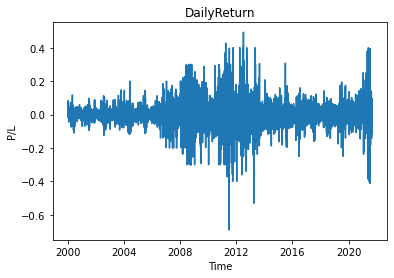

<Figure size 432x288 with 0 Axes>

In [106]:
plt.plot(corn_data['dt'], corn_data['DailyReturn'])

plt.title('DailyReturn')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.show()
plt.savefig('DailyReturn.png', transparent=True)

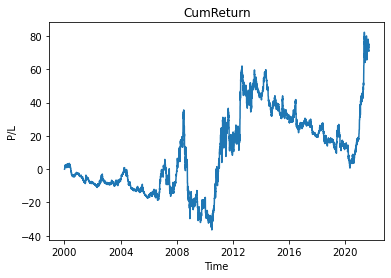

<Figure size 432x288 with 0 Axes>

In [107]:
plt.plot(corn_data['dt'], corn_data['CumReturn'])

plt.title('CumReturn')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.show()
plt.savefig('CumReturn.png', transparent=True)

In [94]:
idx = corn_data.groupby(['Date'])['volume'].transform(max) == corn_data['volume']
corn_data[idx]

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol,maxVolume,DailyReturn,CumReturn
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,2000-01-03,2000-03-14 00:00:00,2000-01,3,121537,True,0,-1
10,CH00,4/1/2000,2.0300,2.0075,2.0350,2.0075,0,34742,14/3/2000,NaN,2000-01-04,2000-03-14 00:00:00,2000-01,3,121537,True,0,-1
19,CH00,5/1/2000,2.0300,2.0250,2.0325,2.0100,0,29534,14/3/2000,NaN,2000-01-05,2000-03-14 00:00:00,2000-01,3,121537,True,0,-1
28,CH00,6/1/2000,2.0375,2.0300,2.0575,2.0300,0,36686,14/3/2000,NaN,2000-01-06,2000-03-14 00:00:00,2000-01,3,121537,True,0,-1
37,CH00,7/1/2000,2.0700,2.0325,2.0775,2.0250,0,46012,14/3/2000,NaN,2000-01-07,2000-03-14 00:00:00,2000-01,3,121537,True,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,2021-08-30,2021-12-14 00:00:00,2021-08,12,414290,True,0,-1
75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,2021-08-31,2021-12-14 00:00:00,2021-08,12,414290,True,0,-1
75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,2021-09-01,2021-12-14 00:00:00,2021-09,12,190162,True,0,-1
75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,2021-09-02,2021-12-14 00:00:00,2021-09,12,190162,True,0,-1


In [381]:
corn_data['maxVolume'] = idx
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,1,0,False
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3,0,True
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,3,0,False
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,5,0,False
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,7,0,False


In [95]:
# contracts with the max volume each day only

corn_data_vol = corn_data[idx].reset_index()
corn_data_vol.tail()

,index,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,dt,exp_dt,month,exp_month,max_vol,maxVolume,DailyReturn,CumReturn
5628,75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,2021-08-30,2021-12-14 00:00:00,2021-08,12,414290,True,0,-1
5629,75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,2021-08-31,2021-12-14 00:00:00,2021-08,12,414290,True,0,-1
5630,75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,2021-09-01,2021-12-14 00:00:00,2021-09,12,190162,True,0,-1
5631,75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,2021-09-02,2021-12-14 00:00:00,2021-09,12,190162,True,0,-1
5632,75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,2021-09-03,2021-12-14 00:00:00,2021-09,12,190162,True,0,-1


In [377]:
def rolling(N, start_date = '3/1/2000', dataframe = corn_data_vol2):
    dailyReturn = [0] * (len(dataframe))
    
    start_date = datetime.strptime(start_date, '%d/%m/%Y')
    row1 = dataframe['dt'] == start_date  # 3/1/2000
    idx1 = dataframe[row1].index[0]  # 0
    running = True
    while running:

        d1_close = dataframe.iloc[idx1]['close']
               
        exp_date = datetime.strptime(dataframe.iloc[idx1]['exp_date'], '%d/%m/%Y')
        roll_date = exp_date - BDay(N)
        
        try:
            row2 = dataframe['dt'] == roll_date
            idx2 = dataframe[row2].index[0]
            exp_date2 = datetime.strptime(dataframe.iloc[idx2]['exp_date'], '%d/%m/%Y')
            if exp_date == exp_date2:
                
                start_date = next_business_date(roll_date)
                row1 = dataframe['dt'] == start_date
                idx1 = dataframe[row1].index[0]
            else:   
                
                d2_close = dataframe.iloc[idx2]['close']
                for i in range(idx2, len(dataframe)):
                    dailyReturn[i] += (d2_close - d1_close) * 5000

                start_date = roll_date
                row1 = dataframe['dt'] == start_date
                idx1 = dataframe[row1].index[0]
            
        except:
            print('error')
            running = False
        
    dataframe1 = dataframe.copy()
    dataframe1['DailyReturn'] = dailyReturn

    return dataframe1

In [378]:
df = rolling(4)
df

error


,index,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,dt,index_column
0,1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3,0.0,2000-01-03,1
1,10,CH00,4/1/2000,2.0300,2.0075,2.0350,2.0075,0,34742,14/3/2000,NaN,3,0.0,2000-01-04,10
2,19,CH00,5/1/2000,2.0300,2.0250,2.0325,2.0100,0,29534,14/3/2000,NaN,3,0.0,2000-01-05,19
3,28,CH00,6/1/2000,2.0375,2.0300,2.0575,2.0300,0,36686,14/3/2000,NaN,3,0.0,2000-01-06,28
4,37,CH00,7/1/2000,2.0700,2.0325,2.0775,2.0250,0,46012,14/3/2000,NaN,3,0.0,2000-01-07,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5628,75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,12,14725.0,2021-08-30,75242
5629,75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,12,14725.0,2021-08-31,75256
5630,75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,12,14725.0,2021-09-01,75270
5631,75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,12,14725.0,2021-09-02,75284


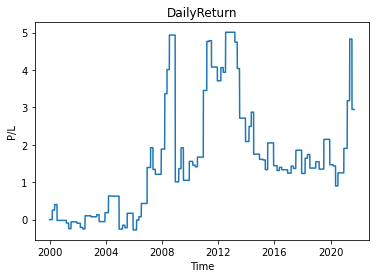

In [374]:
plt.plot(df['dt'], df['DailyReturn'])

plt.title('DailyReturn')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.show()

In [109]:
def get_time_diff(date1, date2):
    date_format = ('%d/%m/%Y')
    try:
        return (datetime.strptime(date2, date_format) - datetime.strptime(date1, date_format)).days
    except:
        return float('-inf')

date_left_list = []
for r in range(len(corn_data)):
    date_left_list.append(get_time_diff(corn_data['Date'].iloc[r], corn_data['exp_date'].iloc[r]))
print(date_left_list[:20])

[375, 71, 436, 130, 193, 557, 255, 346, 711, 374, 70, 435, 129, 192, 556, 254, 345, 710, 373, 69]


In [159]:
def highest_vol_Id(dt):
    
    max_vol = corn_data.groupby('Date')['volume'].max()
    
    return corn_data[corn_data['volume'] == max_vol[dt]]['Id'].values[0]

highest_vol_Id('9/3/2001')

'CK01'

In [147]:
type(a['Id'])

pandas.core.series.Series

In [76]:
corn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75302 entries, 0 to 75301
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 75302 non-null  object 
 1   Date               75302 non-null  object 
 2   close              75302 non-null  float64
 3   open               75302 non-null  float64
 4   high               75302 non-null  float64
 5   low                75302 non-null  float64
 6   open_interest      75302 non-null  int64  
 7   volume             75302 non-null  int64  
 8   exp_date           72120 non-null  object 
 9   first_notice_date  26026 non-null  object 
 10  exp_month          75302 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 6.3+ MB
